In [12]:
import leroi
import numpy as np
import proplot as plot
import warnings
import pyart
import time

In [38]:
filename = '/scratch/kl02/vhl548/cpol/cpol_level_1b/v2020/ppi/2017/20170501/twp10cpolppi.b1.20170501.223000.nc'
field_name = 'corrected_reflectivity'
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    radar = pyart.io.read(filename)
#     radar = leroi.mask_invalid_data(radar, field_name, add_to = [field_name], 
#                                 min_field = 5, min_area = 50, return_smooth = False)

In [22]:
#configure gridding
gs = (40, 601, 601) #grid steps (z,y,x)
gb = ((500, 20000), (-150000,150000),(-150000,150000)) #grid range (z,y,x)
center_pos = (0,0,0) #radar position on Cartesian grid

x = np.linspace(gb[2][0],gb[2][1], gs[2])
y = np.linspace(gb[1][0],gb[1][1], gs[1])
z = np.linspace(gb[0][0],gb[0][1], gs[0])
zz,yy,xx = np.meshgrid(z,y,x,indexing ='ij')

dz, dy, dx = abs(z[1]-z[0]),abs(y[1]-y[0]),abs(x[1]-x[0])
coords = (z-center_pos[0], y-center_pos[1], x-center_pos[2])
print(dz, dy, dx)

500.0 500.0 500.0


In [16]:
# leroi
def leroi_interp(
    radar,
    coords,
    field_names=None,
    gatefilter=None,
    weight_type = 'Barnes',
    Rc=None,
    k=100,
    verbose=True,
    smooth_kw = {'filter_its':0},
    multiprocessing=True,
    ground_elevation=-999,
):
   
    t0 = time.time()

    if field_names is None:
        # No field defined. Processing all fields in radar.
        field_names = [*radar.fields.keys()]
    if type(field_names) != list:
        field_names = [field_names]

    fields = {}
    dims = [len(coord) for coord in coords]

    if Rc is None:
        Rc = leroi.leroi.get_leroy_roi(radar, coords)
        if verbose:
            print("Radius of influence set to {} m.".format(Rc))

    dmask = leroi.leroi.get_data_mask(radar, field_names, gatefilter)
    weights, idxs, model_idxs, sw, model_lens = leroi.leroi._setup_interpolate(
        radar, coords, dmask, weight_type, Rc, multiprocessing, k, verbose
    )
    Z, Y, X = np.meshgrid(coords[0], coords[1], coords[2], indexing="ij")
    ppi_height = leroi.leroi._calculate_ppi_heights(radar, coords, weight_type, Rc, multiprocessing, ground_elevation)
    # fill in the nan heights. If there is no height data, there will be no radar data by definition.
    ppi_height = leroi.leroi.fill_heights(ppi_height)
    
    elevations = radar.fixed_angle["data"]

    # sort sweep index to process from lowest sweep and ascend
    sort_idx = list(np.argsort(elevations))
    if 90.0 in elevations:
        sort_idx.remove(np.argwhere(elevations == 90))

    for field in field_names:
        ppis = np.zeros((radar.nsweeps, dims[1] * dims[2]))
        mask = np.ones((radar.nsweeps, dims[1] * dims[2]))
        for i, j in enumerate(sort_idx):
            slc = radar.get_slice(j)
            data = radar.fields[field]["data"].filled(0)[slc][~dmask[slc]]
            if len(data) > 0:
                ppis[i, model_idxs[i, : model_lens[i]]] = (
                    np.sum(data[idxs[i]] * weights[i], axis=1) / sw[i, model_idxs[i, : model_lens[i]]]
                )
                mask[i, model_idxs[i, : model_lens[i]]] = 0
        out = np.ma.masked_array(
            ppis.reshape((radar.nsweeps, dims[1], dims[2])), mask.reshape((radar.nsweeps, dims[1], dims[2]))
        )
        return out
        grid = leroi.leroi.interp_along_axis(out.filled(np.nan), ppi_height, Z, axis=0, method="linear")

        if smooth_kw['filter_its'] > 0:
            grid = leroi.leroi.smooth_grid(grid, coords, verbose, **smooth_kw)

        # add to output dictionary
        fields[field] = {"data": np.ma.masked_array(grid, mask=np.isnan(grid))}
        # copy the metadata from the radar to the grid
        for key in radar.fields[field].keys():
            if key == "data":
                continue
            fields[field][key] = radar.fields[field][key]

    if verbose:
        print("Took: ", time.time() - t0)

    return fields

out = leroi_field = leroi_interp(radar, coords, [field_name, ], weight_type = 'Barnes')


Radius of influence set to 2440.4763781618394 m.


In [19]:
Rc = leroi.leroi.get_leroy_roi(radar, coords)
ppi_height = leroi.leroi._calculate_ppi_heights(radar, coords, 'Barnes', Rc, True, 0)



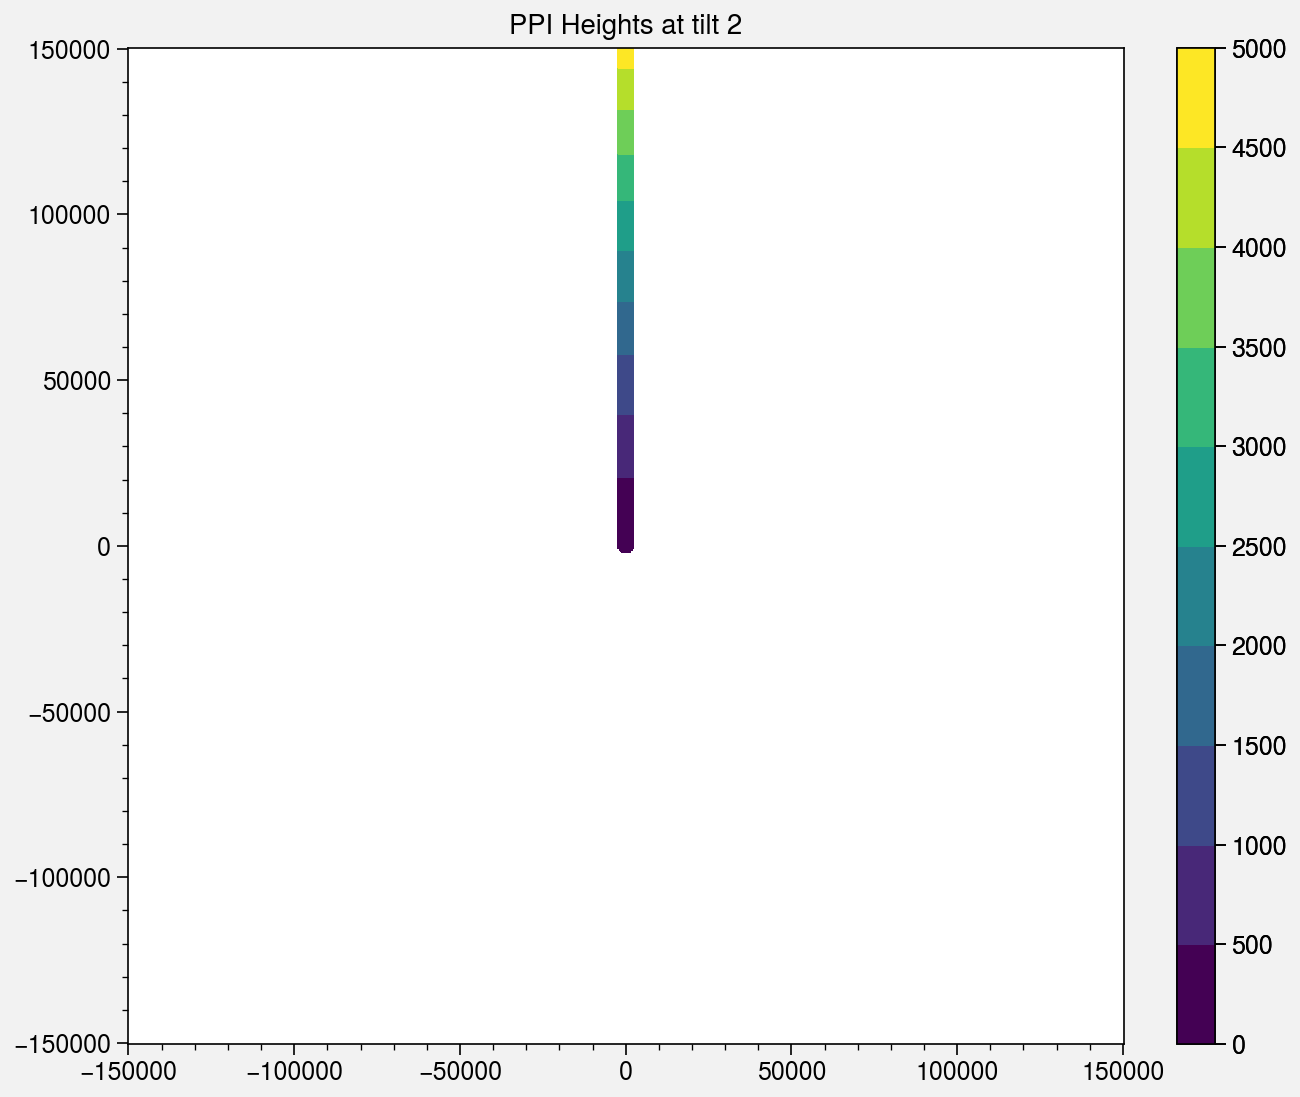

In [44]:
tilt = 2
fig, axs = plot.subplots(nrows =1, journal = 'ams4')
axs[0].pcolormesh(x,y,ppi_height[tilt,...], cmap = 'viridis', colorbar = 'r')
xr,yr,zr = radar.get_gate_x_y_z(tilt)
# axs[1].pcolormesh(xr,yr,radar.fields[field_name]['data'][radar.get_slice(tilt)])
axs.format(title = 'PPI Heights at tilt 2')
plot.show()

In [42]:
radar.get_slice(2)

slice(720, 722, None)